We explore content-based filtering method. Songs are described with a set of lyrics and audio features, or the principal components generated during feature engineering. We assume users prefer to listen to songs that are similar to what they have listened to before.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import json
import ast
import os
import re

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# from yellowbrick.target import FeatureCorrelation
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, RobustScaler, StandardScaler
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

# The following lines adjust the granularity of reporting
# pd.options.display.max_rows = 16
pd.set_option('display.max_columns', None)
# pd.options.display.float_format = "{:.1f}".format
import warnings
warnings.filterwarnings("ignore")

# Importing Data

In [2]:
songs_feature_eng_pca = pd.read_csv(r'../Data/songs_feature_eng_pca.csv',
                                    na_filter=False  #because some track_name and artist_name are called 'null', other features do not have missing values based on previous inspection during dataset construction
)
songs_feature_eng_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230676 entries, 0 to 230675
Data columns (total 55 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   log_listeners        230676 non-null  float64
 1   log_total_playcount  230676 non-null  float64
 2   polarity             230676 non-null  float64
 3   subjectivity         230676 non-null  float64
 4   rms                  230676 non-null  float64
 5   spectral_centroid    230676 non-null  float64
 6   zcr                  230676 non-null  float64
 7   tempo                230676 non-null  float64
 8   mfcc_mean            230676 non-null  float64
 9   mfcc_var             230676 non-null  float64
 10  chroma_mean          230676 non-null  float64
 11  chroma_var           230676 non-null  float64
 12  profanity_low        230676 non-null  float64
 13  profanity_medium     230676 non-null  float64
 14  profanity_high       230676 non-null  float64
 15  duration_short   

# KMeans Clustering

## Using PCA results

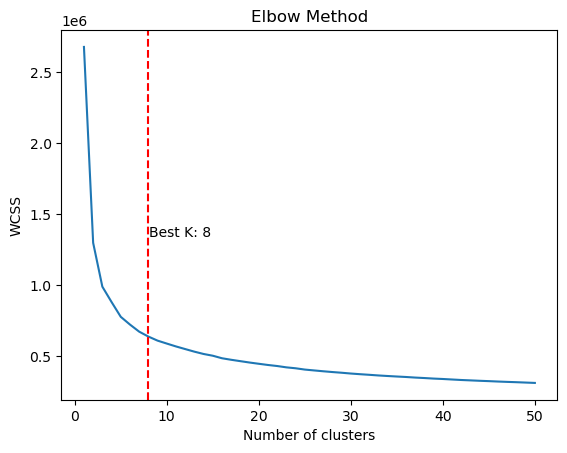

In [18]:
# Using PCA results
X_pca = songs_feature_eng_pca[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']]
# Within-Cluster-Sum-of-Squares
wcss = []
for i in range(1, 51):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=0)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)
# plot the elbow curve
plt.plot(range(1, 51), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# show the best k value
best_k = 8
plt.axvline(x=best_k, linestyle='--', color='red')
plt.text(best_k + 0.1, max(wcss)/2, f'Best K: {best_k}')
plt.show()

[[-1.74484808 -0.20507411  1.3495636  -0.25403119 -0.05778149  0.11172509]
 [-1.68945422 -0.39162521 -0.49841618  0.00989999 -0.05567958  0.06672824]
 [ 5.13563927  3.45723416  0.19843599  0.41271074  0.29812153 -0.42803567]
 [ 4.48409827  0.72477537 -0.02695398 -0.28999009  0.02910503 -0.08537911]
 [-2.59324798  1.50881443 -0.29141091 -0.61739303  0.0088031   0.00716821]
 [-2.61671494  3.55882405  0.28578238  1.74805796 -0.05628219  0.14030405]
 [ 3.2870624  -0.67092923 -0.13710093 -0.1669213  -0.21090825  0.42821962]
 [-0.16773362 -1.45586215  0.11166771  0.48072925  0.16529488 -0.30917293]]
[1 1 7 ... 7 7 0]


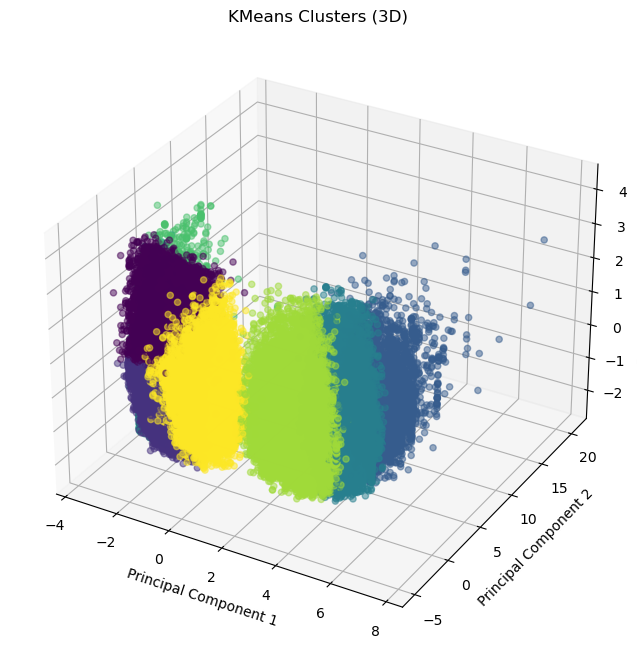

In [19]:
# Applying KMeans clustering with the chosen number of clusters
optimal_clusters = 8
kmeans = KMeans(n_clusters = optimal_clusters, n_init=10, random_state=42)
X_pca['cluster'] = kmeans.fit_predict(X_pca)
centroids = kmeans.cluster_centers_[:, :6]
print(centroids)

# # calculate silhouette score
# silhouette = silhouette_score(X_pca, X_pca['cluster'])
# print(f"Silhouette Score for {optimal_clusters} clusters: {silhouette}")

kmeans_labels = kmeans.labels_
print(kmeans_labels)
# # Visualization of KMeans clusters
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x = X_pca['PC1'], y = X_pca['PC2'], c=kmeans_labels, cmap='rainbow')
# plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', label='centroid')
# plt.title('KMeans Clusters')
# plt.show()

# 3D Scatter plot visualization for the first three principal components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca['PC1'], X_pca['PC2'], X_pca['PC3'], c=X_pca['cluster'], cmap='viridis', alpha=0.5)
ax.set_title('KMeans Clusters (3D)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

In [20]:
# function to recommend songs given a past song
def recommend_kmeans(df, track_name, artist_name, X, centroids, top_k = 30):
    row = df[(df['track_name']==track_name) & (df['artist_name']==artist_name)]
    input_row = row[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']].iloc[0].values.reshape(1, -1)

    # Compute cosine similarity between the input row and each cluster centroid
    similarities = cosine_similarity(input_row, centroids)
    cluster_labels = X['cluster']

    # Get the top 10 songs with the highest similarity to the input row
    indices = np.argsort(similarities)[0][::-1][:1]
    recommended_songs_index = [i for i in range(len(cluster_labels)) if cluster_labels[i] in indices]
    recommended_songs = df.iloc[recommended_songs_index]
    recommended_songs['similarity'] = [cosine_similarity(input_row, song[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']].values.reshape(1, -1))[0][0] for _, song in recommended_songs.iterrows()]
    recommended_songs['cluster'] = cluster_labels.iloc[recommended_songs_index].values
    recommended_songs = recommended_songs.sort_values(by='similarity', ascending=False)[1:top_k+1]
    top_k_songs = recommended_songs[['track_name', 'artist_name', 'similarity', 'cluster']]

    return top_k_songs

In [21]:
X_pca = songs_feature_eng_pca[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']]
optimal_clusters = 8
kmeans = KMeans(n_clusters = optimal_clusters, n_init=10, random_state=42)
X_pca['cluster'] = kmeans.fit_predict(X_pca)
centroids = kmeans.cluster_centers_[:, :6]

# test prediction on one song
recommend_kmeans(songs_feature_eng_pca, 'Cradle', 'Mudvayne', X_pca, centroids)

,track_name,artist_name,similarity,cluster
43429,Knock You Out,Bingo Players,0.992885,1
170740,Prayer to God,Shellac,0.992638,1
185550,Breaking Bones,Vök,0.992587,1
34888,21 Questions,Waterparks,0.991768,1
144321,Hi Fever,Ecco2K,0.991297,1
24311,Face 2 Face,Juice WRLD,0.990409,1
189711,Beat My Head Against the Wall,Black Flag,0.989606,1
1957,Witchfinder General,Witchfinder General,0.989347,1
95776,Snow Charges,Jeff Rosenstock,0.989214,1
54695,Cenotaph,Bolt Thrower,0.988878,1


## Using Song Features

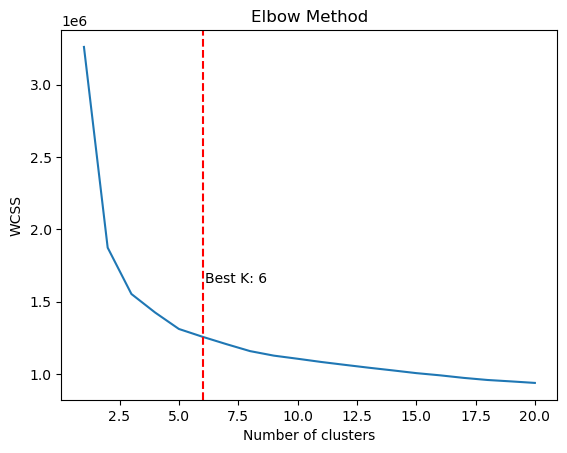

In [22]:
# X with feature engineering
eng_features = ['log_listeners', 'log_total_playcount', 'polarity', 'subjectivity',
       'rms', 'spectral_centroid', 'zcr', 'tempo', 'mfcc_mean', 'mfcc_var',
       'chroma_mean', 'chroma_var', 'profanity_low', 'profanity_medium',
       'profanity_high', 'duration_short', 'duration_medium', 'duration_long',
       'emotion_anger', 'emotion_disgust', 'emotion_fear', 'emotion_joy',
       'emotion_negative', 'emotion_positive', 'emotion_sadness',
       'emotion_surprise', 'emotion_trust', 'mfcc_1', 'mfcc_2', 'mfcc_3',
       'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10',
       'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16',
       'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20']
X_eng = songs_feature_eng_pca[eng_features]
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=0)
    kmeans.fit(X_eng)
    wcss.append(kmeans.inertia_)

# plot the elbow curve
plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# show the best k value
best_k = 6
plt.axvline(x=best_k, linestyle='--', color='red')
plt.text(best_k + 0.1, max(wcss)/2, f'Best K: {best_k}')

plt.show()

In [23]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
kmeans.fit(X_eng)
cluster_labels = kmeans.predict(X_eng)
centroids = kmeans.cluster_centers_
# print(centroids)
kmeans_labels = kmeans.labels_
np.unique(kmeans_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5]),
 array([22956, 61743, 20845, 41368, 26710, 57054], dtype=int64))